In [1]:
import os
import itertools
import matplotlib.pyplot as plt
import pandas as pd 
import pvlib
import numpy as np
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib import tracking
from pvlib.bifacial.pvfactors import pvfactors_timeseries
from pvlib import temperature
from pvlib.pvsystem import PVSystem, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS


from pvlib.iotools import read_tmy3
from matplotlib import rcParams


rcParams['figure.figsize'] = 20, 6
rcParams['lines.linewidth'] = 2.5

/Users/yaizabermudez/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
df_prod = pd.read_csv("data/Merged_2020-2022_weather_data.csv")

In [25]:
df_prod['DateHeure'] = pd.to_datetime(df_prod.DateHeure, format ='%Y-%m-%d %H:%M:%S') 
df_prod.set_index('DateHeure', inplace=True)
df_prod.sort_index(inplace=True)
df_floor = df_prod['Prod. Photovoltaique (kWh)']

In [5]:
data_frame_roof = df_roof.copy()


## Physical model

In [6]:
lat = 45.20 # Latitude Grenoble
lon = 5.70 # Longitude Grenoble
tz = 'Etc/GMT-2'
altitude = 212

In [7]:
start = '2020-01-01'
end = '2022-12-31 23:00:00'

data_frame_roof = data_frame_roof.loc[data_frame_roof.index <= end]
data_frame_roof = data_frame_roof.loc[data_frame_roof.index >= start]
real  = data_frame_roof.values

times = pd.date_range(start, end, freq='1H', tz=tz)

In [8]:
def physical_val(lat=45.20, lon=5.7, altitude=212, surface_tilt=10, surface_azimuth=60, tz='Etc/GMT-2', times = times):

    # create location object and get clearsky data
    site_location = Location(lat, lon,  tz=tz, altitude = altitude, name='Grenoble')

    #compute solar position trough times 
    solar_position = site_location.get_solarposition(times)

    # Compute absolute airmass
    airmass_relative  = pvlib.atmosphere.get_relative_airmass(solar_position['zenith'])
    airmass_absolute = pvlib.atmosphere.get_absolute_airmass(airmass_relative)

    # Compute aoi
    incidence_angle = pvlib.irradiance.aoi(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth, solar_zenith= solar_position['zenith'], 
                            solar_azimuth= solar_position['azimuth'])
    
    return solar_position,airmass_relative, airmass_absolute, incidence_angle, site_location





In [9]:
s_position, airmass_r, airmass_a, angle, location = physical_val()

In [10]:
def calcule_pred(model_clear_sky, solar_position, airmass_absolute, incidence_angle, site_location, power=183, model_irrad = 'haydavies', tilt=6, angle=139): 
    # cs = site_location.get_clearsky(times)
    module = pvlib.pvsystem.retrieve_sam('SandiaMod')['Schott_Solar_ASE_300_DGF_50__320___2007__E__']
    cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
    
    sapm_system = PVSystem(
        surface_tilt= tilt, 
        surface_azimuth= angle,
        module_parameters=module,
        inverter_parameters=cec_inverters,
        temperature_model_parameters=temperature_model_parameters
    )
    # print(sapm_system)
    
    irradiance = PVSystem.get_irradiance(sapm_system, solar_position['zenith'], solar_position['azimuth'], model_clear_sky['dni'], model_clear_sky['ghi'], model_clear_sky['dhi'], model=model_irrad)

   
    # Compute effective irradiance
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(irradiance['poa_direct'], irradiance['poa_diffuse'], airmass_absolute, 
                                                  incidence_angle, module )

    # celltemp = pvlib.pvsystem.sapm_celltemp(irradiance['poa_direct'], wind, temperature)
    m_pow = (module["Impo"] * module["Vmpo"]) 
    
    df_pred=solar_position.copy()

    pv_produced = pvlib.pvsystem.sapm(effective_irradiance, 25, module)
    pv_produced ["p_mp"] = (pv_produced ["p_mp"]* power)/(m_pow/1000) 

    pv_produced ["p_mp"] /=1000  # kWh

    df_pred['power'] = pv_produced['p_mp']

    df_pred = df_pred.loc[df_pred.index >= start]
    df_pred = df_pred.loc[df_pred.index <= end]
    df_pred = df_pred['power']
    

    return df_pred

In [11]:
linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon, filepath=None, interp_turbidity=True)

In [12]:
model_ineichen= pvlib.clearsky.ineichen(s_position['apparent_zenith'], airmass_a, linke_turbidity, altitude=212, dni_extra=1364.0, perez_enhancement=False)

In [13]:
df_pred = calcule_pred(model_ineichen, s_position, airmass_a, angle, location, power=22, model_irrad = 'haydavies', tilt=10, angle=67  )
pred = df_pred.values

NameError: name 'data_frame_floor' is not defined

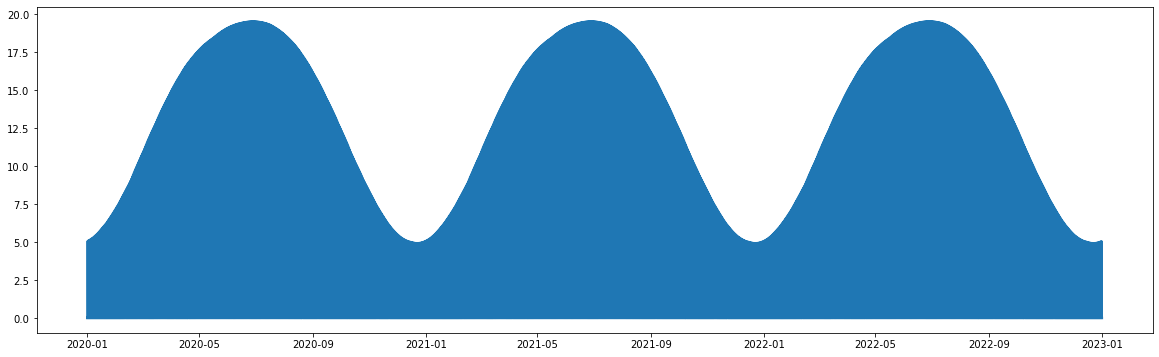

In [14]:
plt.plot(df_pred)
plt.plot(data_frame_floor)
plt.ylabel('KiloWatts')
plt.xlabel("Time")
plt.show()

In [37]:
#df_pred.to_csv('data/pred_2020_2022.csv')